# IBM Data Science Capstone

## Introduction

This article is the final assignment in my IBM Data Science Professional Certificate, a crash course in basic data science techniques. I have been tasked with leveraging the Foursquare API to perform an analysis of my choosing using their `venue` data.

In this article, I will examine the neighborhoods of Seattle, and cluster them into groups of similar neighborhoods based on the venues they contain. A "Venue" is defined by Foursquare as: 

*Real places or real events. Places where people can meet up or like to spend some time...Places where people like to check in.*

They are everything from shops and restaurants to statues and bus stations. If you have ever searched a map for "coffee shop" or "pizza near me", the results you got were venues.

This analysis could be valuable to several groups of people. For example, business owners with a successful business in one neighborhood may be interested in similar areas where they could expand. Or perhaps residents planning to move between neighborhoods might want to know what neighborhoods are similar (or dissimilar) to where they currently live. 

In [1]:
# Imports, needed for code throughout the analysis
import pandas as pd
import numpy as np
import os
import requests
import folium
import geopy.distance
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from math import cos, radians
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns

## Data

The data used in this analysis comes from 2 sources. 

First, we need geographic data for Seattle's neighborhoods. This is downloaded from an open data set (found [here](https://gis-kingcounty.opendata.arcgis.com/datasets/neighborhood-centers-in-king-county-neighborhood-centers-point), under the "Download" menu). This data defines 46 different neighborhoods of Seattle and provides latitude and longitude coordinates for each.

I decided to drop neighborhoods that were far from the city center, and arbitrarily decided that 13km was the cutoff. Calculating distances in terms of latitude and longitude coordinates is actually quite complicated (fun fact: the curvature of the Earth must be accounted for), but fortunately the `geopy` library does the hard work for you. 33 neighborhoods remained within the cutoff distance.

In [2]:
df = pd.read_csv("Neighborhood_Centers_in_King_County___neighborhood_centers_point.csv")
df = df[['NAME', 'LATITUDE', 'LONGITUDE' ]]

seattle_coordinates = (47.6062, -122.3321)

distances = []
for idx, neighborhood in df.iterrows():
    neighborhood_coordinates = (neighborhood.LATITUDE, neighborhood.LONGITUDE)
    km_to_city_center = geopy.distance.distance(seattle_coordinates, neighborhood_coordinates).km
    distances.append(km_to_city_center)
df['KM_TO_CITY_CENTER'] = distances
drop_cities_farther_than = 13
df = df[df['KM_TO_CITY_CENTER'] <= drop_cities_farther_than]
df.drop('KM_TO_CITY_CENTER', axis=1, inplace=True)
df['NAME'] = df['NAME'].apply(lambda x: x.replace(' Neighborhood', ''))
df = df.rename(columns={'NAME': 'NEIGHBORHOOD'})
df.reset_index(drop=True, inplace=True)
df.head(10)

,NEIGHBORHOOD,LATITUDE,LONGITUDE
0,Northgate,47.708593,-122.323276
1,Lake City,47.719278,-122.295228
2,Wedgewood,47.675783,-122.290273
3,University District,47.661268,-122.313133
4,Green Lake,47.679490,-122.325846
5,Greenwood,47.690593,-122.355302
6,North Beach,47.701541,-122.390056
7,Crown Hill,47.690607,-122.376806
8,Ballard,47.668679,-122.386370
9,Fremont,47.649588,-122.349749


Let's see those neighborhoods on a map:

In [24]:
seattle_map = folium.Map(location=seattle_coordinates, zoom_start=11)

for lat, lng, neighborhood in zip(df['LATITUDE'], df['LONGITUDE'], df['NEIGHBORHOOD']):
    label = folium.Popup(neighborhood, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        color='blue',
        fill=True,
        fill_opacity=1.0,
        popup=label
    ).add_to(seattle_map)
# Uncomment to show map
# seattle_map

#### *Screenshot of map, in case Notebook is untrusted:*

![image](seattle_map.png)

Next, we need to get venue data for each neighborhood. We will fetch this from the Foursquare API. This data contains numerous details for each venue, but we are mainly concerned with the venue's category. There are hundreds of types of category, but they are all sub-categories of the following 10 top level categories:
- Arts & Entertainment
- College & University
- Event
- Food
- Nightlife Spot
- Outdoors & Recreation
- Professional & Other Places
- Residence
- Shop & Service
- Travel & Transport

To get the venue data, we need to iterate through every category for every neighborhood and make a request to the Foursquare API for each. The design of the API creates a limitation, as it is only capable of returning venues within a certain radius of a point. Unfortunately, the neighborhoods of Seattle are not shaped like perfect circles, so we will not get all the venues in a neighborhood, but it will have to do. I arbitrarily chose a radius of 250 meters.

Fetching this data requires doing `10 categories * 33 neighborhoods = 330 requests` to the API. Fortunately this is within the daily usage limits of the free tier. 

While testing these results, I noticed that many of the requests returned the API limit of 50 venues (for example, Capitol Hill has at least 50 `Food` venues). This was a problem because if a neighborhood had more than 50 venues of a certain category, some of them would be left out and this would represent that neighborhood inaccurately. 

To get around this, if a request returned 50 venues, I would then perform a subsearch of that same area. I submitted 4 new requests to the API, each one searching a radius of 125 meters (half the original 250 meters) and centered 125 meters North, South, East, and West of the original search. These 4 subsearches are all contained within the original search, but do not cover all of it so it is possible that some venues were missed. These subsearches also overlap, so duplicate venues needed to be removed.

Following is the code used to do this. Note that you need your own Foursquare credentials (foursquare_client_id and foursquare_client_secret) if you want to run the analysis yourself! Or just skip this code block and read the results from the csv file in the code block below.

In [87]:
# Warning: running this code block makes hundreds of calls to the Foursquare API (and won't work without you adding your own API credentials)
category_ids = {
    'Arts & Entertainment': '4d4b7104d754a06370d81259',
    'College & University': '4d4b7105d754a06372d81259',
    'Event': '4d4b7105d754a06373d81259',
    'Food': '4d4b7105d754a06374d81259',
    'Nightlife Spot': '4d4b7105d754a06376d81259',
    'Outdoors & Recreation': '4d4b7105d754a06377d81259',
    'Professional & Other Places': '4d4b7105d754a06375d81259',
    'Residence' : '4e67e38e036454776db1fb3a',
    'Shop & Service': '4d4b7105d754a06378d81259',
    'Travel & Transport': '4d4b7105d754a06379d81259'
}

# Sorry, you need your own credentials!
foursquare_client_id = os.environ['FOURSQUARE_CLIENT_ID']
foursquare_client_secret = os.environ['FOURSQUARE_CLIENT_SECRET']

auth_params = 'client_id={}&client_secret={}'.format(foursquare_client_id, foursquare_client_secret)
version_params = 'v=20200101'

def assemble_foursquare_url(base, params=[]):
    url = base + '?' + auth_params + '&' + version_params
    for param in params:
        url += '&' + str(param)
    return url
def get_venues_for_neighborhood(radius, category_id, latitude, longitude):
    url_base = 'https://api.foursquare.com/v2/venues/search'
    url_params = ['limit=50', 'radius={}'.format(radius), 'categoryId={}'.format(category_id), 'll={},{}'.format(latitude, longitude)]
    url = assemble_foursquare_url(url_base, url_params)
    response = requests.get(url)
    venues = response.json()['response']['venues']
    return venues
    
def offset_latitude(original, offset):
    return original + offset / 111111

def offset_longitude(original, offset, latitude):
    return original + offset / (111111 * cos(radians(latitude)))
    
def get_venues_for_all_neighborhoods(dataframe, category):
    if category not in category_ids:
        raise Exception(category, 'is not a valid category')
    venue_df = pd.DataFrame(columns=['name', 'categories', 'TOP_LEVEL_CATEGORY', 'NEIGHBORHOOD', 'NEIGHBORHOOD_LAT', 'NEIGHBORHOOD_LNG'])
    for idx, row in dataframe.iterrows():
        radius = 250
#         print('Fetching', category, 'venues for neighborhood:', row.NEIGHBORHOOD)
        venues = get_venues_for_neighborhood(radius, category_ids[category], row.LATITUDE, row.LONGITUDE)
#         print(len(venues), 'venues found!')
        if len(venues) == 50:
#             print("Max venues found! Subsearching...")
            offset = radius // 2
            new_points = []
            new_points.append((offset_latitude(row.LATITUDE, offset), row.LONGITUDE))
            new_points.append((offset_latitude(row.LATITUDE, -offset), row.LONGITUDE))
            new_points.append((row.LATITUDE, offset_longitude(row.LONGITUDE, offset, row.LATITUDE)))
            new_points.append((row.LATITUDE, offset_longitude(row.LONGITUDE, -offset, row.LATITUDE)))
            for pt in new_points:
                venues = get_venues_for_neighborhood(offset, category_ids[category], pt[0], pt[1])
#                 print("subsearch found", len(venues), "venues")
                temp_df = pd.DataFrame(venues)
                temp_df['NEIGHBORHOOD'] = row.NEIGHBORHOOD
                temp_df['NEIGHBORHOOD_LAT'] = row.LATITUDE
                temp_df['NEIGHBORHOOD_LNG'] = row.LONGITUDE
                temp_df['TOP_LEVEL_CATEGORY'] = category
                venue_df = venue_df.append(temp_df)
        else:
            temp_df = pd.DataFrame(venues)
            temp_df['NEIGHBORHOOD'] = row.NEIGHBORHOOD
            temp_df['NEIGHBORHOOD_LAT'] = row.LATITUDE
            temp_df['NEIGHBORHOOD_LNG'] = row.LONGITUDE
            temp_df['TOP_LEVEL_CATEGORY'] = category
            venue_df = venue_df.append(temp_df)
    venue_df = venue_df[['name', 'categories', 'TOP_LEVEL_CATEGORY', 'NEIGHBORHOOD', 'NEIGHBORHOOD_LAT', 'NEIGHBORHOOD_LNG']]
    venue_df['categories'] = venue_df['categories'].apply(lambda c: c[0]['name'])
    venue_df = venue_df.rename(columns={"name": "VENUE", "categories": "CATEGORY"})
    venue_df.drop_duplicates(inplace=True)
    return venue_df

vdf = pd.DataFrame()
for category in category_ids:
    vdf = vdf.append(get_venues_for_all_neighborhoods(df, category))

vdf.to_csv('seattle_venues.csv', index_label=False)

If you don't want to bother setting up a Foursquare Developer account (I don't blame you), you can just get the results I used from a csv file.

Note that if you do run it again, you might get slightly different results as venues in the Foursquare database are added, removed, or modified.

In [89]:
# Read from csv file
vdf = pd.read_csv('seattle_venues.csv')
vdf = vdf.sort_values(by='VENUE')
vdf['NEIGHBORHOOD'] = vdf['NEIGHBORHOOD'].apply(lambda x: x.replace(' Neighborhood', ''))
vdf.reset_index(drop=True, inplace=True)
print('{} venues found!'.format(vdf.shape[0]))
vdf[['VENUE', 'CATEGORY', 'TOP_LEVEL_CATEGORY', 'NEIGHBORHOOD']].head(10)

4598 venues found!


,VENUE,CATEGORY,TOP_LEVEL_CATEGORY,NEIGHBORHOOD
0,100 West Harrison Plaza North Tower,Building,Professional & Other Places,Queen Anne
1,10th floor UW Towers,Office,Professional & Other Places,University District
2,112th &.5th,Rest Area,Travel & Transport,Northgate
3,114 bus to Newcastle,Bus Line,Travel & Transport,International District
4,"1220 Seneca St Seattle, WA",Residential Building (Apartment / Condo),Residence,Central Business District
5,125th & Lake City Way Ne Metro Bus Stop 41 64 65,Bus Station,Travel & Transport,Lake City
6,126 25th Ave E,Housing Development,Residence,Central District
7,1401 Apartments,Residential Building (Apartment / Condo),Residence,Capitol Hill
8,1404 Boylston,Building,Residence,Capitol Hill
9,1411 Fourth Avenue Building,Building,Professional & Other Places,Central Business District


## Methodology

In order to compare different neighborhoods using their respective venues, we must make some decisions about how we are going to interpret their venue data. 

First we must decide whether to use `CATEGORY` or `TOP_LEVEL_CATEGORY` to distinguish venue types. We can see how many unique values there are in each column, as well as get an idea how often they occur.

In [90]:
print('Unique CATEGORY values:', len(vdf.CATEGORY.unique()))
print('Unique TOP_LEVEL_CATEGORY values:', len(vdf.TOP_LEVEL_CATEGORY.unique()))
print('Mean frequency for CATEGORY values:', round(vdf.groupby('CATEGORY').count()['VENUE'].mean(), 2))
print('Mean frequency for TOP_LEVEL_CATEGORY values:', round(vdf.groupby('TOP_LEVEL_CATEGORY').count()['VENUE'].mean(), 2))

Unique CATEGORY values: 439
Unique TOP_LEVEL_CATEGORY values: 9
Mean frequency for CATEGORY values: 10.47
Mean frequency for TOP_LEVEL_CATEGORY values: 510.89


We can see that there are `439` different values in `CATEGORY` but only `10` different values in `TOP_LEVEL_CATEGORY`. Every unique value in these columns is considered to be fully unique (for example a `"Pizza Shop"` and `"Pizza Parlor"` would have no association, yet in reality they are similar) which would make it difficult to find similarities between our neighborhoods with the 439 different values in `CATEGORY`. For this reason, I decided to use `TOP_LEVEL_CATEGORY` in my analysis.

As a side note, it may be possible to use the fine-grained detail in `CATEGORY` while still maintaining some level of association between `CATEGORY` values with the same `TOP_LEVEL_CATEGORY`, but I am still learning and did not explore this option for the sake of simplicity.

Next we must decide how to measure our venues for the sake of comparison. 

We could use the count of each category in a neighborhood. This would cluster neighborhoods together that have similar amounts of venues in similar categories.

Alternatively, we could determine the percentage each category represents of all categories in a neighborhood. This would cluster together neighborhoods that have a similar ratios of each category.

I think the first option is better, because it captures more information about a neighborhood. It would give us both the relative and absolute quantities for each category in a neighborhood.

#### Data Preparation

The data needs to be processed before it can be used by our clustering algorithm. We extract the category for each venue and sum them for each neighborhood. Then we apply a standard scaler to each column. Here is the code for this step. Note that vdf is our venue DataFrame and the array shown outside of the slightly darker box is a sample of the result. 

In [91]:
vdf_onehot = pd.get_dummies(vdf[['TOP_LEVEL_CATEGORY']], prefix='', prefix_sep='')
vdf_onehot['NEIGHBORHOOD'] = vdf['NEIGHBORHOOD']

vdf_sum = vdf_onehot.groupby('NEIGHBORHOOD').sum()

scaled = StandardScaler().fit_transform(np.asarray(vdf_sum))
scaled[:3]

array([[-0.25915374, -0.26442201,  0.06986166, -0.02367126, -0.03322256,
        -0.39549419,  0.14960655,  0.52764748, -0.54460758],
       [-0.25915374, -0.35438002, -0.08383399, -0.28405516, -0.20189093,
        -1.0053684 , -0.39895081, -0.72766269, -0.9395977 ],
       [ 0.80985545, -0.35438002,  0.5002095 ,  1.71222141,  1.48479277,
         1.37314103,  0.25931803,  0.64912911,  0.14662512]])

The array above shows the first 3 elements of the prepared data. Each of these 3 elements represents a neighborhood. Each neighborhood is a list of 9 float values, each representing a category. You may remember that there were 10 categories initially, but not a single neighborhood had a venue of type Event, so it has been removed. The float values represent the count of venues in that category, but they have been standardized. They are the number of standard deviations away from the mean for that column, which is harder for humans to read, but important to do for our clustering algorithm.

#### K Means Clustering

There are numerous clustering techniques we could use, but I have chosen to use one called K Means. I chose this algorithm because it is simple and works for unlabeled data. 

The first step in using this algorithm is finding a suitable value for K (It should be noted that K is the number of clusters). This is done by performing the clustering with multiple values of K and comparing their accuracy. I arbitrarily decide K should be in the range of 2 and 8, because there must be at least 2 clusters, and with only 33 neighborhoods to consider, having too many clusters wouldn't tell us anything meaningful.

The following visualization shows the Inertia (the "distance" between neighborhoods in the same cluster) for different values of K. A low Inertia is good.

<function matplotlib.pyplot.show(close=None, block=None)>

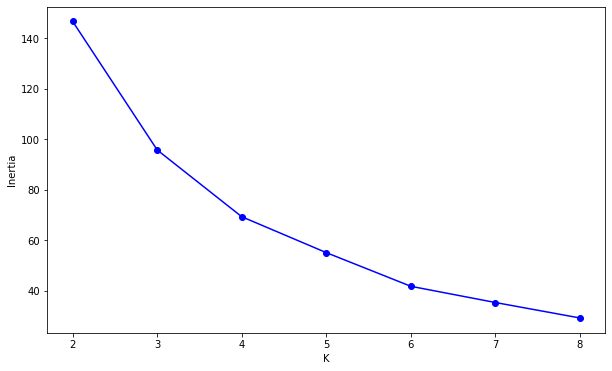

In [92]:
rand = 1
errors = []
K = range(2,9)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=rand).fit(scaled)
    errors.append(kmeans.inertia_)

plt.figure(figsize=(10,6))
plt.plot(K, errors, 'bo-')
plt.xticks(K)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show

Notice that as K increases, the Inertia (error) continues to drop. Intuitively, this makes sense; the more clusters you introduce, the fewer neighborhoods each cluster contains, and the closer it can match their features. If you have as many clusters as you have neighborhoods, then each neighborhood would get its own cluster and the error would be 0. But this wouldn't be a very useful application of a clustering algorithm. Our goal is to find an acceptable error value with a reasonable value for K.

To do this, we are looking for an "elbow" in the chart; where the line goes from going sharply downward to sharply to the right. Such an elbow represents the point where increasing K has a diminished effect at reducing the error. This is the sweet spot for K. Unfortunately, there is no elbow to be seen in this chart, so we must try a different method.

Our next test will evaluate the Silhouette Score for the same values of K. The Silhouette Score measures both how close neighborhoods of one cluster are as well as how well separated they are from other clusters. A higher Silhouette Score is better. 

<function matplotlib.pyplot.show(close=None, block=None)>

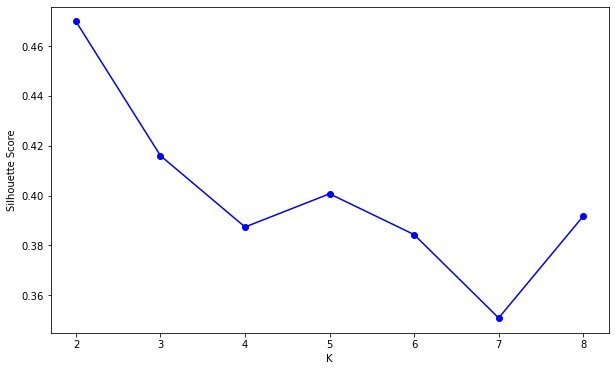

In [93]:
sil = []
K = range(2,9)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=rand).fit(scaled)
    labels = kmeans.labels_
    sil.append(silhouette_score(scaled, labels, metric = 'euclidean'))

plt.figure(figsize=(10,6))
plt.plot(K, sil, 'bo-')
plt.xticks(K)
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.show

Now we are looking for peaks while also picking an acceptable value for K. There are peaks K is set to 2, 5, and 8. I think 2 would be too few clusters to be meaningful. 5 and 8 have similar scores, but I think 5 is a better choice because it will make observations later in this analysis easier. So we will choose K=5, and group our neighborhoods into 5 clusters.


#### Results

The model assigns each neighborhood to a cluster. We will add a `CLUSTER` column to our original geographic dataframe to represent this assignment.

In [94]:
kmeans = KMeans(n_clusters=5, random_state=rand).fit(scaled)
vdf_sum['CLUSTER'] = kmeans.labels_

df_clustered = df.merge(vdf_sum[['CLUSTER']], left_on='NEIGHBORHOOD', right_on='NEIGHBORHOOD')
df_clustered.rename({'CLUSTER_y': 'CLUSTER'}, axis=1, inplace=True)
df_clustered.sort_values(by=['CLUSTER'], inplace=True)
df_clustered.reset_index(drop=True, inplace=True)
df_clustered

,NEIGHBORHOOD,LATITUDE,LONGITUDE,CLUSTER
0,Northgate,47.708593,-122.323276,0
1,Admiral,47.581194,-122.386548,0
2,Columbia City,47.557847,-122.285044,0
3,Georgetown,47.547926,-122.316094,0
4,Magnolia,47.639553,-122.401007,0
5,White Center,47.517352,-122.354020,0
6,Central District,47.619169,-122.302550,0
7,Wallingford,47.661386,-122.333720,0
8,West Seattle,47.561105,-122.386779,0
9,Lake City,47.719278,-122.295228,0


Finally, let us display our clustered neighborhoods on a map like before, using colors to represent the different clusters.

In [95]:
seattle_map_clustered = folium.Map(location=seattle_coordinates, zoom_start=11)

palette = {
    0: 'darkorange',
    1: 'blue',
    2: 'green',
    3: 'darkred',
    4: 'purple',
}

for lat, lng, name, cluster in zip(df_clustered['LATITUDE'], df_clustered['LONGITUDE'], df_clustered['NEIGHBORHOOD'], df_clustered['CLUSTER']):
    popup_text = '{}\nCluster: {}'.format(name, cluster)
    _popup = folium.Popup(popup_text, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        color=palette[cluster],
        fill=True,
        fill_opacity=1.0,
        popup=_popup
    ).add_to(seattle_map_clustered)
# Uncomment to show map
# seattle_map_clustered

#### *Screenshot of map, in case Notebook is untrusted:*

![image](clustered_seattle_map.png)

Let's also visualize information about each cluster's characteristics. The following bar chart shows the average number of venues in each neighborhood for each cluster.

Text(0.5, 0, 'Average Venues per Neighborhood')

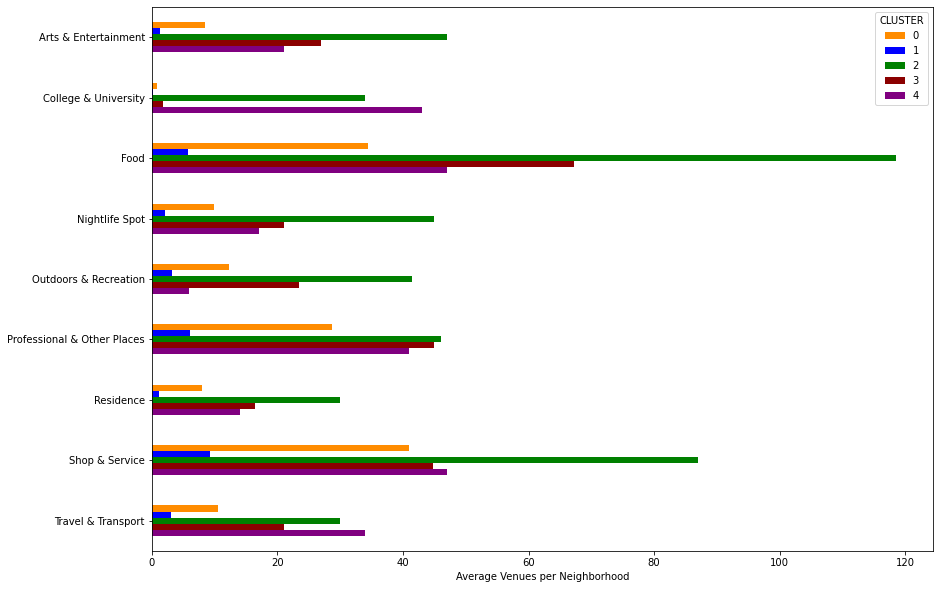

In [96]:
profiles = vdf_sum.groupby('CLUSTER').mean().transpose()

ax = profiles.plot.barh(figsize=(14,10), color=palette)

ax.invert_yaxis()
plt.xlabel('Average Venues per Neighborhood')

Finally, let's visualize the venue density for each cluster.

Text(0, 0.5, 'Average Venues per Neighborhood')

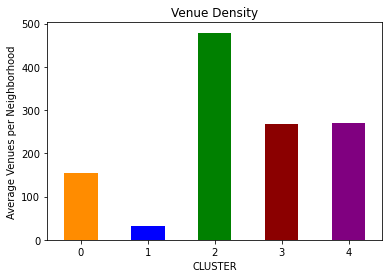

In [97]:
vdf_sum.groupby('CLUSTER').mean().transpose().sum().plot.bar(color=palette.values(),rot=0)
plt.title('Venue Density')
plt.ylabel('Average Venues per Neighborhood')

## Discussion

Using these charts and the map, we can make some assumptions about each cluster, and give them more human-readable names.

##### Cluster 0 - High Density Suburb
From the map, we can see that this is a semi-suburban cluster. This assertion is backed up by the fact that it has the second lowest density. Neighborhoods in this cluster have all the amenities of their more populated counterparts, but in lower quantities.

##### Cluster 1 - Low Density Suburb
This is the lowest density cluster. It has few venues of all types, and is likely not a place people often visit without living there.

##### Cluster 2 - Dense Commercial District
This is the highest density cluster. From the map, we can see that it contains 2 neighborhoods right in the heart of the city. It has the greatest number of shopping, dining, and entertainment venues, and is likely a destination for those things. It has a proportionally lower amount of `Professional & Other Places` venues, which is a surprise considering one of the two neighborhoods is the Central Business District. It also has many `College & University` venues, signaling the presence of colleges or universities.

##### Cluster 3 - Commercial District
This cluster has a similar venue composition to the Dense Commercial District cluster, but at a lower density. Its neighborhoods would likely be similar, yet smaller destinations for shopping, dining, and entertainment. 

##### Cluster 4 - College Campus
This cluster is an outlier, as it only contains a single neighborhood. It has similar venues to the 2 *Commercial* clusters, but with the highest proportion of `College & University` venues by far. There is also a high quantity of `Travel & Transport` venues, likely as a result of the University there.

Let's see the map again with our names for each cluster.

![image](clustered_seattle_map_with_legend.png)

Our approach was bound to be somewhat flawed, due to several limitations:
- There is more to a neighborhood than the venues it contains. Asserting that two neighborhoods are similar based on that information alone might be inadequate. 

- We could not evaluate a neighborhood precisely because we could only search for venues in perfect circles. Any venues more than 250 meters from the points on the map were missed.

- We have no way of knowing how accurate the geographic data is that defined the neighborhoods in the first place. Were any neighborhoods missing? Are the points that define them where they should be?

- All venues were considered equal. However, some venues might define a neighborhood than others. For example, consider the impact of a football stadium compared to a statue in the park.

In spite of these limitations, I found the results to be surprisingly reasonable. The way that the clusters lay out on the map (particularly how they radiate from the city center) seems sensible for any city. 

I can also offer my anecdotal opinion: I lived in Seattle for several years, and would have clustered the neighborhoods similarly if put to the task.

## Conclusion

In this report we saw how K Means clustering could be used to group neighborhoods based on what venues they contain. We applied this approach to the neighborhoods of Seattle and analyzed the results, coming up with names for each cluster. The approach had some limitations but ultimately produced a reasonable result.

Thanks for reading!